## Generating Traffic Image Data

#### 1. Configuring setup

In [1]:
import os
import csv
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
train_dir = Path("Image_Data/Training/Filled/"); train_dir.mkdir(parents = True, exist_ok = True)

train_missing_dir_5 = Path("Image_Data/Training/Missing/five/"); train_missing_dir_5.mkdir(parents = True, exist_ok = True)
train_missing_dir_15 = Path("Image_Data/Training/Missing/fifteen/"); train_missing_dir_15.mkdir(parents = True, exist_ok = True)
train_missing_dir_25 = Path("Image_Data/Training/Missing/twenty-five/"); train_missing_dir_25.mkdir(parents = True, exist_ok = True)

test_dir = Path("Image_Data/Testing/Filled/"); test_dir.mkdir(parents = True, exist_ok = True)

test_missing_dir_5 = Path("Image_Data/Testing/Missing/five/"); test_missing_dir_5.mkdir(parents = True, exist_ok = True)
test_missing_dir_15 = Path("Image_Data/Testing/Missing/fifteen/"); test_missing_dir_15.mkdir(parents = True, exist_ok = True)
test_missing_dir_25 = Path("Image_Data/Testing/Missing/twenty-five/"); test_missing_dir_25.mkdir(parents = True, exist_ok = True)

pd.set_option('display.max_columns', None, 'display.max_rows', None)

#### 2. Constructing the traffic observation data-frame

In [3]:
## Initializing traffic_data data-frame
traffic_data = pd.DataFrame()

## Concatenating each data file to traffic_data
for year in os.listdir('Traffic_Data/'):
    for file_name in os.listdir(os.path.join('Traffic_Data', year)):
        file = pd.read_csv(os.path.join('Traffic_Data', year, file_name))
        traffic_data = pd.concat([traffic_data, file], axis = 0)
        
## Changing 'Hour' variable to datetime and sorting by date
traffic_data['Hour'] = pd.to_datetime(traffic_data['Hour'])
traffic_data = traffic_data.sort_values('Hour').reset_index(drop = True)

## Reading California I-5 sensor information
all_sensors = pd.read_csv('Misc_Data/pems_sensors.csv'); all_sensors['ID'] = all_sensors['ID'].astype(str)

## Extracting columns from traffic_data data-frame
data_sensors = pd.DataFrame({'Sensor': traffic_data.drop(columns = ['Hour', '# Lane Points', '% Observed']).columns})
data_sensors['ID'] = data_sensors['Sensor'].str.split('-', n = 1, expand = True)[0].astype(str)

## Inner joining data-frames and sorting by ordering (S --> N, San Diego --> Oregon)
new_sensors = data_sensors.merge(all_sensors, how = 'inner', on = 'ID').sort_values('Ordering').reset_index(drop = True)

## Extracting proper column ordering and adding 'Hour' to the beginning
all_columns = new_sensors['Sensor'].tolist()
all_columns.insert(0, 'Hour')

## Changing column ordering of traffic_data
traffic_data = traffic_data[all_columns]

## Dropping all columns in traffic_data with missing values
traffic_data = traffic_data.dropna(axis = 'columns')

## Cutting some rows to make n_cols % 10 = 0
traffic_data = traffic_data.iloc[:, 0:461]

## Cutting some rows to make n_rows % 200 = 0
traffic_data = traffic_data.iloc[0:40000,]

## Saving 'Hour' variable
hour = traffic_data['Hour']

#### 3. Data preprocessing and saving data-frames to 'Output' folder

In [4]:
## Removing 'Hour' variable for scaling
traffic_data = traffic_data.drop(columns = ['Hour'])

## Flattening the data for quicker operations
flat_data = traffic_data.to_numpy().flatten().astype(int)

## Storing the min, max, and dimensions
minimum = np.min(flat_data); maximum = np.max(flat_data)
n = traffic_data.shape[0]; p = traffic_data.shape[1]

## Scaling data to be between 0-254
flat_data = 254 * (flat_data - minimum) / (maximum - minimum)

## Reshaping the array back to its original shape
scaled_data = pd.DataFrame(flat_data.reshape((n, p)), columns = traffic_data.columns)

In [5]:
## Defining function to randomly remove a given proportion of observations
def delete(col, frac):
    col.loc[col.sample(frac = frac).index] = np.nan
    return col

In [6]:
## traffic_data - complete and scaled data-frame
traffic_data = scaled_data.copy()
pd.concat([hour, traffic_data], axis = 1).to_csv('Output_Data/traffic_data.csv', index = False)

## Creating data-frames with missing values
traffic_data_missing_5 = scaled_data.apply(delete, axis = 0, frac = 0.05)
traffic_data_missing_15 = scaled_data.apply(delete, axis = 0, frac = 0.15)
traffic_data_missing_25 = scaled_data.apply(delete, axis = 0, frac = 0.25)

## traffic_data_mapped_5 - all missing values mapped to 255
traffic_data_mapped_5 = traffic_data_missing_5.fillna(value = 255)
pd.concat([hour, traffic_data_mapped_5], axis = 1).to_csv('Output_Data/traffic_data_mapped_5.csv', index = False)

## traffic_data_mapped_15 - all missing values mapped to 255
traffic_data_mapped_15 = traffic_data_missing_15.fillna(value = 255)
pd.concat([hour, traffic_data_mapped_15], axis = 1).to_csv('Output_Data/traffic_data_mapped_15.csv', index = False)

## traffic_data_mapped_25 - all missing values mapped to 255
traffic_data_mapped_25 = traffic_data_missing_25.fillna(value = 255)
pd.concat([hour, traffic_data_mapped_25], axis = 1).to_csv('Output_Data/traffic_data_mapped_25.csv', index = False)

#### 4. Generating training images

In [7]:
## Function to generate images and store to disk
def generate_training_images(df, image_dir, idx_start, idx_end):
    
    ## Initializing list to store images
    images = list()

    ## Initializing data windows
    #n_time_windows = 192; n_sensor_windows = 27
    n_time_windows = 32; n_sensor_windows = 16
    
    ## Subsetting the data-frame
    df = df.iloc[idx_start:idx_end,]

    for i in range(0, n_time_windows):
        for j in range(0, n_sensor_windows):

            ## Locking in data windows
            time_loc = [(i * 200), (i * 200 + 200)]; sensor_loc = [(j * 10), (j * 10 + 200)]

            ## Creating img with window subset
            img = np.array(df.iloc[time_loc[0]:time_loc[1], sensor_loc[0]:sensor_loc[1]])

            ## Appending to lists
            images.append(img)
    
    ## Sanity check
    print("Loaded traffic data:")
    print(f" - np.shape(images) {np.shape(images)}")
    
    ## Storing images to disk
    store_many_disk(images, image_dir)
    
def store_many_disk(images, image_dir):
    
    ## Saving images one by one
    for i, image in enumerate(images):
        storing = Image.fromarray(image)
        storing = storing.convert('L')
        storing.save(image_dir / f"{i}.png")
    print(f'-- {i+1} images saved to disk -- ')
    
## Defining indices for training set
train_idx_start = 0; train_idx_end = 38400

## Storing training images to disk
generate_training_images(traffic_data, train_dir, train_idx_start, train_idx_end)
generate_training_images(traffic_data_mapped_5, train_missing_dir_5, train_idx_start, train_idx_end)
generate_training_images(traffic_data_mapped_15, train_missing_dir_15, train_idx_start, train_idx_end)
generate_training_images(traffic_data_mapped_25, train_missing_dir_25, train_idx_start, train_idx_end)

Loaded traffic data:
 - np.shape(images) (512, 200, 200)
-- 512 images saved to disk -- 
Loaded traffic data:
 - np.shape(images) (512, 200, 200)
-- 512 images saved to disk -- 
Loaded traffic data:
 - np.shape(images) (512, 200, 200)
-- 512 images saved to disk -- 
Loaded traffic data:
 - np.shape(images) (512, 200, 200)
-- 512 images saved to disk -- 


#### 5. Generating testing images

In [8]:
## Function to generate images and store to disk
def generate_testing_images(df, image_dir, idx_start, idx_end):
    
    ## Initializing list to store images
    images = list()

    ## Initializing data windows
    n_time_windows = 2; n_sensor_windows = 5
    
    ## Subsetting the data-frame
    df = df.iloc[idx_start:idx_end,].reset_index(drop = True)

    for i in range(0, n_time_windows):
        for j in range(0, n_sensor_windows):

            ## Locking in data windows
            time_loc = [(i * 300), (i * 300 + 200)]; sensor_loc = [(j * 50), (j * 50 + 200)]

            ## Creating img with window subset
            img = np.array(df.iloc[time_loc[0]:time_loc[1], sensor_loc[0]:sensor_loc[1]])
            
            ## Appending to lists
            images.append(img)
    
    ## Sanity check
    print("Loaded traffic data:")
    print(f" - np.shape(images) {np.shape(images)}")
    
    ## Storing images to disk
    store_many_disk(images, image_dir)
    
def store_many_disk(images, image_dir):
    
    ## Saving images one by one
    for i, image in enumerate(images):
        storing = Image.fromarray(image)
        storing = storing.convert('L')
        storing.save(image_dir / f"{i}.png")
    print(f'-- {i+1} images saved to disk -- ')
    
## Defining indices for testing set
test_idx_start = 38400; test_idx_end = 40000

## Storing training images to disk
generate_testing_images(traffic_data, test_dir, test_idx_start, test_idx_end)
generate_testing_images(traffic_data_mapped_5, test_missing_dir_5, test_idx_start, test_idx_end)
generate_testing_images(traffic_data_mapped_15, test_missing_dir_15, test_idx_start, test_idx_end)
generate_testing_images(traffic_data_mapped_25, test_missing_dir_25, test_idx_start, test_idx_end)

(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
Loaded traffic data:
 - np.shape(images) (10, 200, 200)
-- 10 images saved to disk -- 
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
Loaded traffic data:
 - np.shape(images) (10, 200, 200)
-- 10 images saved to disk -- 
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
Loaded traffic data:
 - np.shape(images) (10, 200, 200)
-- 10 images saved to disk -- 
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
Loaded traffic data:
 - np.shape(images) (10, 200, 200)
-- 10 images saved to disk -- 


#### 6. Sanity Check: Dislaying a sample image 

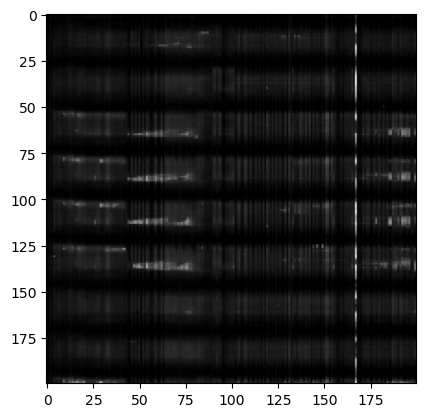

In [9]:
## Function to read n_images from disk
def read_many_disk(n_images):
    images = []
    for image_id in range(n_images):
        images.append(np.array(Image.open(train_dir / f"{image_id}.png")))
    return images

## Reading in a samplle image
n_images = 1
imgs = read_many_disk(n_images)

## Plotting an example training image
plt.imshow(imgs[0], cmap = 'gray')
plt.show()

#### All images using the traffic data are now stored on disk and ready to be used by the encoder-decoder model.